In [2]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from source.qBN.qBNMC import qBayesNet
from source.qBN.qBNRejection import qInference
from source.qBN.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import random

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

In [97]:
alarm_bn = gum.loadBN("alarm.dsl")

In [108]:
def getRandomBinaryCPT(num_parents):
    if num_parents <= 0:
        r = random.random()
        return [r, 1-r]
    else:
        return [getRandomBinaryCPT(num_parents-1), getRandomBinaryCPT(num_parents-1)]

In [112]:
def randomChoice(elements, num_choice):
    res = set()
    for i in range(num_choice):
        chosen = random.choice(list(elements))
        elements.discard(chosen)
        res.add(chosen)
    return res

In [109]:
binary_bn = gum.BayesNet('Binary BN')

for n_id in alarm_bn.nodes():
    binary_bn.add(gum.LabelizedVariable(alarm_bn.variable(n_id).name(), alarm_bn.variable(n_id).description(), 2))

for tail, head in alarm_bn.arcs():
    binary_bn.addArc(tail, head)

for n_id in alarm_bn.nodes():
    binary_bn.cpt(n_id)[:] = getRandomBinaryCPT(len(binary_bn.parents(n_id)))

In [110]:
binary_bn.cpt(30)

(pyAgrum.Potential<double>@0x5566a5c32780) 
                           ||  CATECHOL         |
ARTCO2|SAO2  |TPR   |INSUFF||0        |1        |
------|------|------|------||---------|---------|
0     |0     |0     |0     || 0.2954  | 0.7046  |
1     |0     |0     |0     || 0.5199  | 0.4801  |
0     |1     |0     |0     || 0.0402  | 0.9598  |
1     |1     |0     |0     || 0.4287  | 0.5713  |
0     |0     |1     |0     || 0.4390  | 0.5610  |
1     |0     |1     |0     || 0.7525  | 0.2475  |
[...4 more line(s) ...]
0     |1     |0     |1     || 0.0061  | 0.9939  |
1     |1     |0     |1     || 0.5742  | 0.4258  |
0     |0     |1     |1     || 0.7567  | 0.2433  |
1     |0     |1     |1     || 0.1587  | 0.8413  |
0     |1     |1     |1     || 0.7499  | 0.2501  |
1     |1     |1     |1     || 0.8366  | 0.1634  |

In [190]:
import numpy as np
e = np.eye(int(4.524e4))
e.size/1e6

2046.6576

In [185]:
(2**31)/1e6

2147.483648

In [195]:
np.eye(int(2**15))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [3]:
bn0 = gum.BayesNet("bn")
for i in range(10):
    bn0.add(gum.LabelizedVariable(str(i),str(i),2))

In [5]:
qbn0 = qBayesNet(bn0)
qc0 = qbn0.buildCircuit()
qinf0 = qInference(qbn0)
qinf0.setEvidence({0:0})
qinf0.getGates()

In [94]:
qbn = qBayesNet(binary_bn)
qc = qbn.buildCircuit(add_measure=True)

In [148]:
num_runs = 1
num_evidence_var = 10
max_iter = 2000

for i in range(num_runs):

    #Randomly Chosen Evidence and Target
    n_ids = binary_bn.nodes()
    evidence = {ev_id: random.randint(0,1) for ev_id in randomChoice(n_ids, num_evidence_var)}
    target = randomChoice(n_ids, 1)

    #Lazy Propagation Benchmark
    ie = gum.LazyPropagation(binary_bn)
    ie.setEvidence(evidence)
    ie.makeInference()
    print(f"Evidence: {evidence}, Target: {target}")
    print(f"Evidence probability ({num_evidence_var} values): {ie.evidenceProbability()}")

    #Quantum Rejection Sampling
    qinf = qInference(qbn)
    qrt = qRuntime(qinf, backend)
    qinf.setEvidence(evidence)
    qinf.setMaxIter(max_iter)
    qinf.makeInference()
    qinf_run_time = qrt.rejectionSamplingRuntime()
    qinf_max_error = (qinf.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"QS - Run time: {qinf_run_time}, Max Error: {qinf_max_error}")

    #Monte Carlo Classical Rejection Sampling
    mc = gum.MonteCarloSampling(binary_bn)
    mc.setEpsilon(1e-20)
    mc.setMaxTime(1e20)
    mc.setEvidence(evidence)
    mc.setMaxIter(max_iter)
    mc.makeInference()
    mc_run_time = mc.currentTime()
    mc_max_error = (mc.posterior(target).toarray() - ie.posterior(target).toarray()).max()
    print(f"MC - Run time: {mc_run_time}, Max Error: {mc_max_error}")


Evidence: {1: 1, 3: 0, 5: 1, 8: 0, 14: 0, 15: 0, 20: 0, 23: 1, 24: 1, 31: 0}, Target: {12}
Evidence probability (10 values): 6.952018710175363e-05


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [111]:
evidence = {"MINVOLSET": 0, "DISCONNECT": 0}
ie = gum.LazyPropagation(binary_bn)
ie.setEvidence(evidence)
ie.makeInference()
print(f"Evidence: {evidence}")
print(f"Evidence probability: {ie.evidenceProbability()}")

Evidence: {'MINVOLSET': 0, 'DISCONNECT': 0}
Evidence probability: 0.05825177497125137


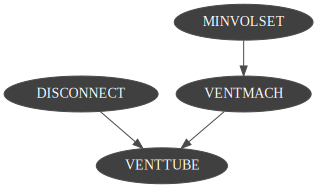

In [8]:
qinf = qInference(qbn)
qinf.setEvidence(evidence)
qinf.setMaxIter(1000)
qinf.useFragmentBN(target={target_node})
gnb.showBN(qinf.qbn.bn, size=20)

In [9]:
qinf.getGates()

In [10]:
qinf.makeInference()

{'VENTMACH': [0.06100000000000005, 0.9240000000000007, 0.007, 0.008],
 'DISCONNECT': [1.0000000000000007, 0],
 'MINVOLSET': [1.0000000000000007, 0, 0],
 'VENTTUBE': [0.9670000000000007,
  0.006,
  0.016000000000000007,
  0.011000000000000003]}

In [11]:
gnb.sideBySide(qinf.posterior(target_node),
               ie.posterior(target_node),
               captions=["qInference", "LazyPropagation"])

In [15]:
mc = gum.MonteCarloSampling(bn)
mc.setEvidence(evidence)
mc.setMaxIter(10000)
mc.makeInference()

In [30]:
r = mc.posterior(target_node).toarray() - ie.posterior(target_node).toarray()

In [32]:
r.max()

0.003758412832682745

In [22]:
r.max()

0.003758412832682745

In [17]:
mc.messageApproximationScheme()

'stopped with max iteration=10000'